# 01 — Exploratory Data Analysis (EDA)

## Project: Retail Store Sales – Time Series Forecasting

Цель этого ноутбука:

- Разобраться в структуре данных (формат, колонки, типы).
- Понять поведение целевой переменной `sales` во времени.
- Выявить тренды, сезонность, выбросы и пропуски.
- Сформулировать гипотезы и идеи для последующих моделей и feature engineering.


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Графики по умолчанию
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)

# Настройки отображения pandas
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


## 1. Загрузка данных

Данные взяты из Kaggle-датасета **Store Sales – Time Series Forecasting** (Corporación Favorita).

В этом ноутбуке используем файл:

- `data/raw/train.csv`

Основные колонки:
- `date` — дата.
- `store_nbr` — идентификатор магазина.
- `family` — категория товара.
- `sales` — целевая переменная (объем продаж).
- `onpromotion` — количество единиц товара на акции.


In [5]:
DATA_PATH = "../data/raw/train.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         str    
 2   store_nbr    int64  
 3   family       str    
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), str(2)
memory usage: 137.4 MB


In [7]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3000888.0,NaN,NaN,NaN,1500443.5,866281.891642,0.0,750221.75,1500443.5,2250665.25,3000887.0
date,3000888,1684,2013-01-01,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_nbr,3000888.0,NaN,NaN,NaN,27.5,15.585787,1.0,14.0,27.5,41.0,54.0
family,3000888,33,AUTOMOTIVE,90936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.0,NaN,NaN,NaN,357.775749,1101.997721,0.0,0.0,11.0,195.84725,124717.0
onpromotion,3000888.0,NaN,NaN,NaN,2.60277,12.218882,0.0,0.0,0.0,0.0,741.0


In [8]:
df.isna().mean().sort_values(ascending=False)


id             0.0
date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
dtype: float64

## 2. Data Structure — Initial Observations

Основные характеристики датасета:

- Более **3 млн наблюдений**, каждое соответствует продаже конкретной категории товара
  в конкретном магазине в конкретный день.
- Данные имеют **панельную структуру** `(date, store_nbr, family)`.
- Целевая переменная — `sales`.
- Признак `onpromotion` отражает количество товаров, находящихся на акции,
  и потенциально является важным фактором спроса.
- Пропущенные значения отсутствуют, что упрощает preprocessing.

Для дальнейшего анализа временных зависимостей
дата будет приведена к формату `datetime`,
а также будут добавлены календарные признаки.


In [9]:
# Преобразуем дату в datetime
df["date"] = pd.to_datetime(df["date"])

# Отсортируем по дате
df = df.sort_values("date").reset_index(drop=True)

# Добавим базовые временные признаки
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek  # 0 = Monday
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)

df.head()


,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,weekofyear
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1
1,1194,2013-01-01,42,CELEBRATION,0.0,0,2013,1,1,1,1
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,2013,1,1,1,1
3,1192,2013-01-01,42,BOOKS,0.0,0,2013,1,1,1,1
4,1191,2013-01-01,42,BEVERAGES,0.0,0,2013,1,1,1,1


## 3. Total Daily Sales Time Series

На первом этапе рассмотрим **суммарные ежедневные продажи**
по всем магазинам и категориям товаров.

Агрегация `sales` по дате позволяет:

- оценить общий масштаб бизнеса,
- выявить долгосрочный тренд,
- обнаружить сезонные паттерны и аномальные периоды.


In [10]:
daily_sales = (
    df.groupby("date", as_index=False)["sales"]
    .sum()
    .rename(columns={"sales": "total_sales"})
)

daily_sales.head()


,date,total_sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


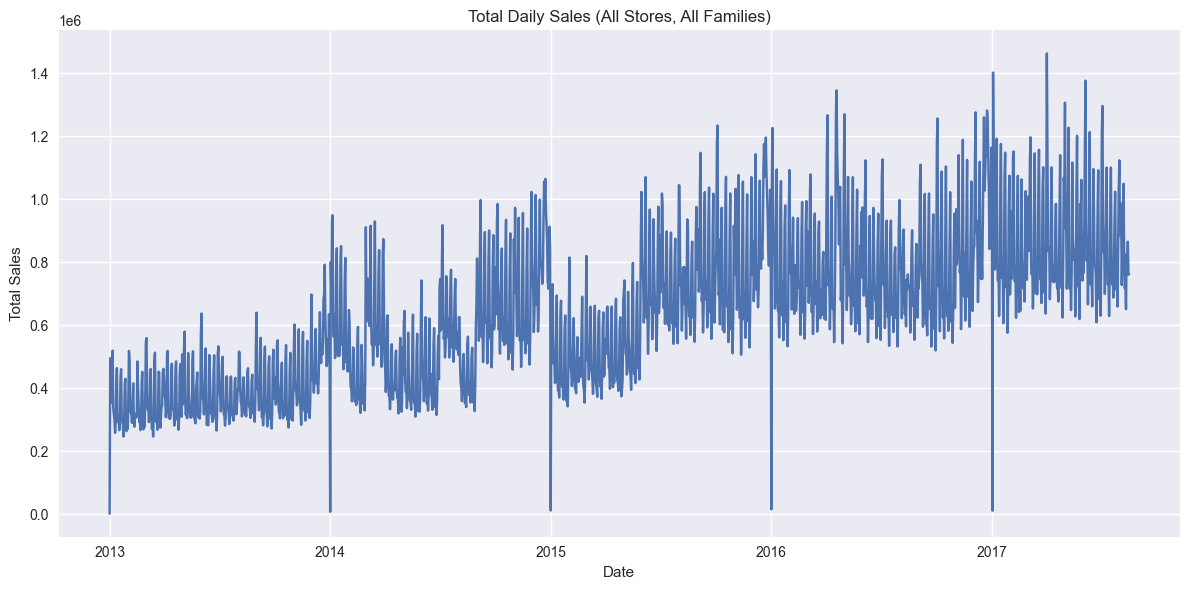

In [11]:
plt.plot(daily_sales["date"], daily_sales["total_sales"])
plt.title("Total Daily Sales (All Stores, All Families)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


### Observations from the Aggregate Time Series

По общему временному ряду можно выделить следующие особенности:

- Наблюдается выраженный **долгосрочный восходящий тренд**.
- Присутствует **повторяющаяся сезонность**, проявляющаяся в регулярных колебаниях.
- В ряде дат наблюдаются резкие падения продаж почти до нуля,
  что, вероятно, соответствует праздничным дням или закрытию магазинов.

Данные особенности необходимо учитывать при построении моделей прогнозирования.


## 4. Weekly and Monthly Seasonality

Для более детального анализа сезонных эффектов
рассмотрим средние продажи:

- по дням недели,
- по месяцам года.

Это позволяет выявить регулярные паттерны спроса,
связанные с календарными циклами.


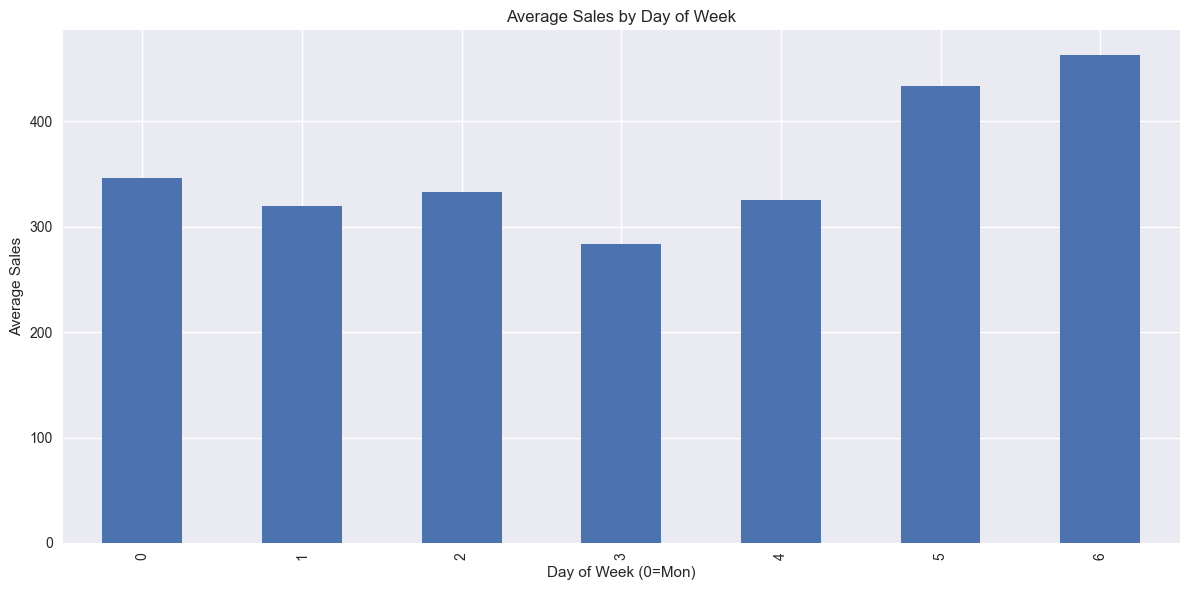

In [12]:
dow_sales = (
    df.groupby("dayofweek")["sales"]
    .mean()
    .reindex(range(7))
)

ax = dow_sales.plot(kind="bar")
ax.set_title("Average Sales by Day of Week")
ax.set_xlabel("Day of Week (0=Mon)")
ax.set_ylabel("Average Sales")
plt.tight_layout()
plt.show()


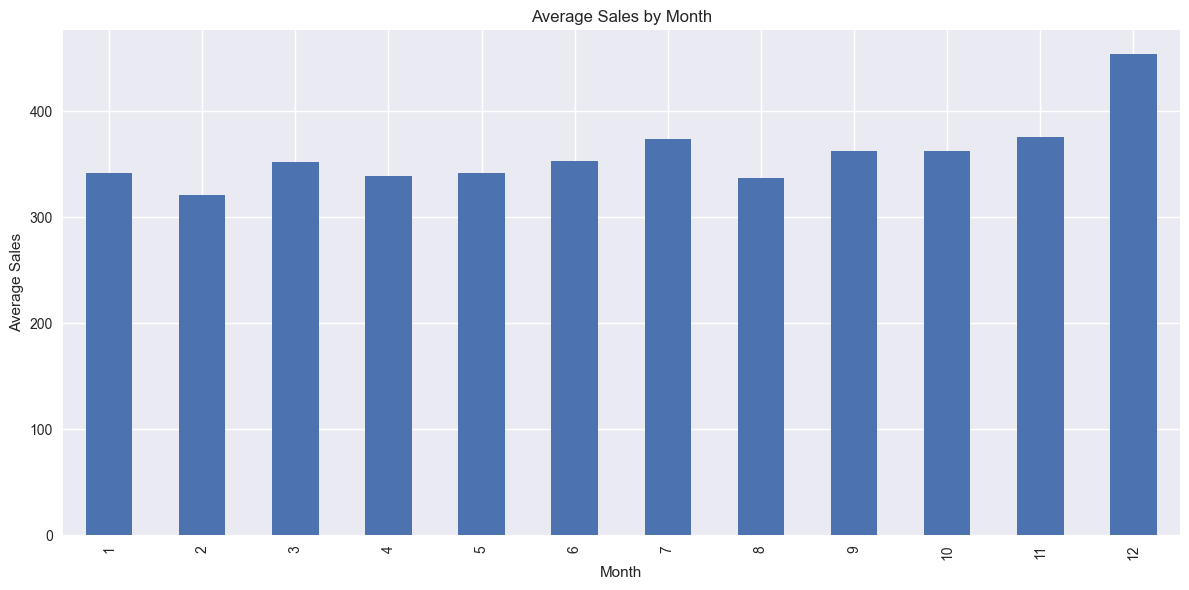

In [13]:
monthly_sales = (
    df.groupby("month")["sales"]
    .mean()
    .reindex(range(1, 13))
)

ax = monthly_sales.plot(kind="bar")
ax.set_title("Average Sales by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Average Sales")
plt.tight_layout()
plt.show()


### Seasonality Insights

- Наблюдается ярко выраженная **недельная сезонность**:
  продажи значительно выше в выходные дни по сравнению с буднями.
- Месячная агрегация показывает **годовую сезонность**,
  с усилением спроса во второй половине года и пиком в декабре.

Наличие устойчивых сезонных паттернов указывает на необходимость
использования календарных признаков и сезонных компонентов в моделях.


## 5. Distribution of Daily Sales and Outliers

Далее рассмотрим распределение суммарных ежедневных продаж,
а также наличие экстремальных значений.

Этот анализ важен для:

- понимания масштаба и формы распределения целевой переменной,
- выбора подходящих метрик качества,
- принятия решений о возможных преобразованиях данных.


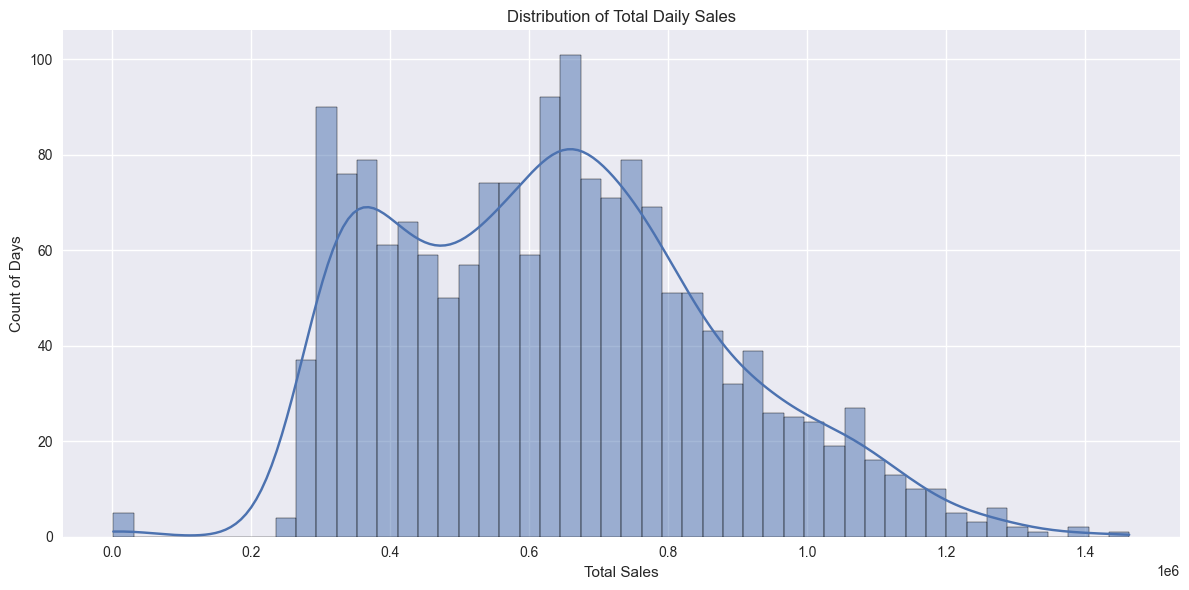

In [14]:
sns.histplot(daily_sales["total_sales"], bins=50, kde=True)
plt.title("Distribution of Total Daily Sales")
plt.xlabel("Total Sales")
plt.ylabel("Count of Days")
plt.tight_layout()
plt.show()


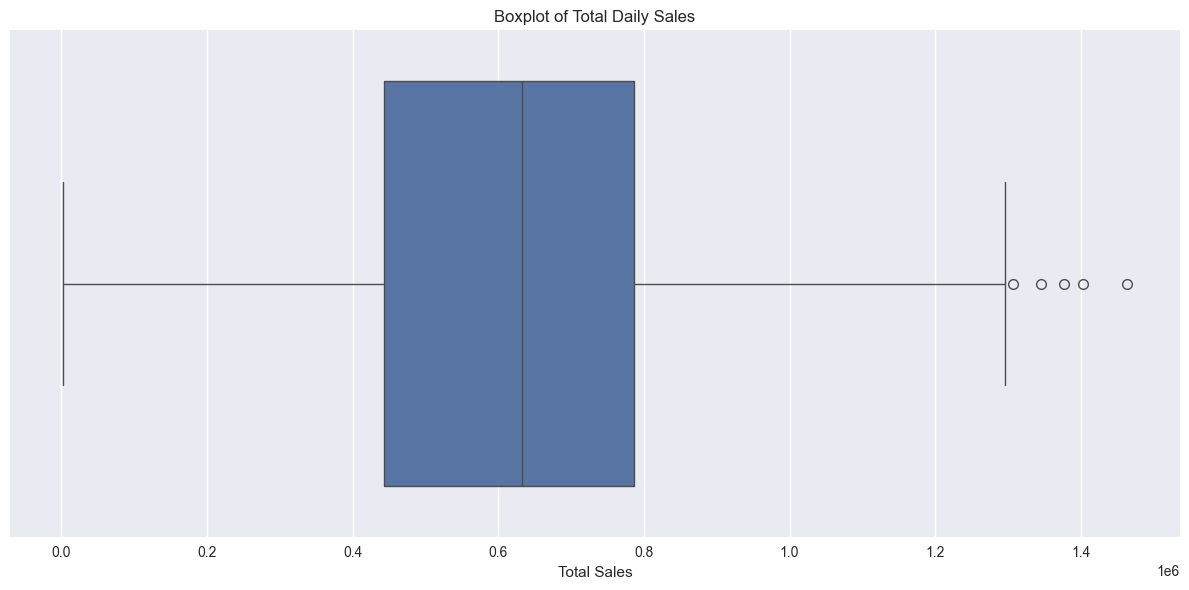

In [15]:
sns.boxplot(x=daily_sales["total_sales"])
plt.title("Boxplot of Total Daily Sales")
plt.xlabel("Total Sales")
plt.tight_layout()
plt.show()


### Outlier Analysis

- Распределение продаж является **сильно скошенным вправо**
  с длинным хвостом высоких значений.
- Выбросы соответствуют реальным дням с аномально высоким спросом
  (праздники, масштабные акции), а не ошибкам данных.
- Такие наблюдения не должны удаляться,
  однако они могут существенно влиять на метрики,
  особенно чувствительные к большим ошибкам (например, RMSE).


## 6. Store- and Category-Level Analysis

Продажи значительно различаются:

- между разными магазинами (`store_nbr`),
- между различными категориями товаров (`family`).

Для иллюстрации этой неоднородности
были рассмотрены:

- Top-5 магазинов по суммарным продажам и их временная динамика,
- Top-5 товарных категорий и их поведение во времени.


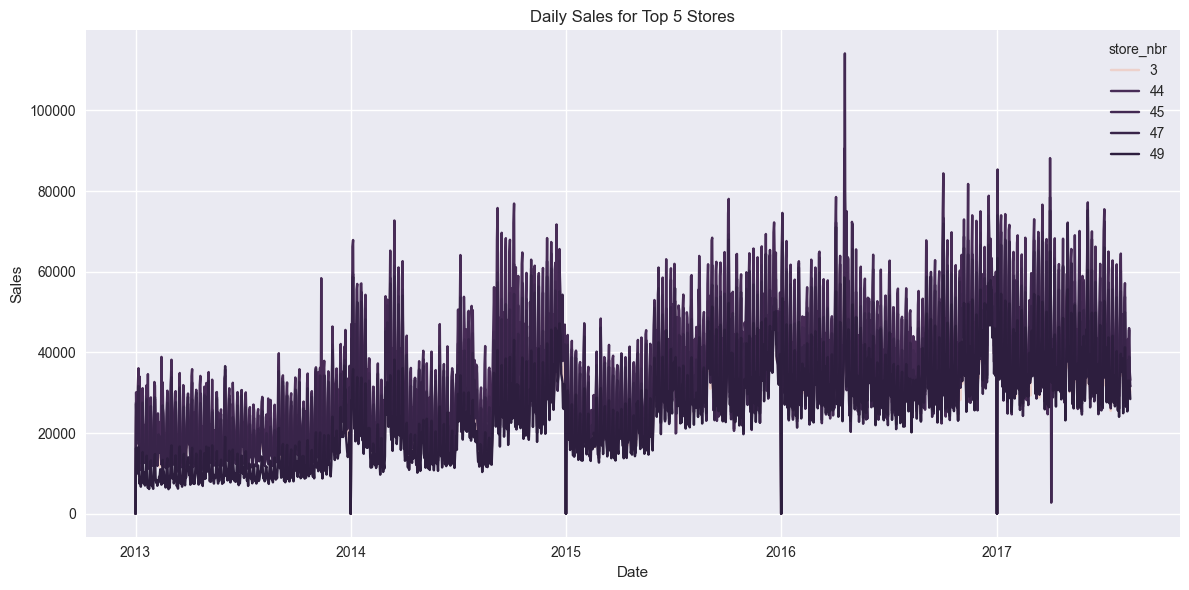

In [16]:
top_stores = (
    df.groupby("store_nbr")["sales"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

df_top_stores = df[df["store_nbr"].isin(top_stores)]

store_daily = (
    df_top_stores.groupby(["date", "store_nbr"])["sales"]
    .sum()
    .reset_index()
)

sns.lineplot(
    data=store_daily,
    x="date",
    y="sales",
    hue="store_nbr"
)
plt.title("Daily Sales for Top 5 Stores")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


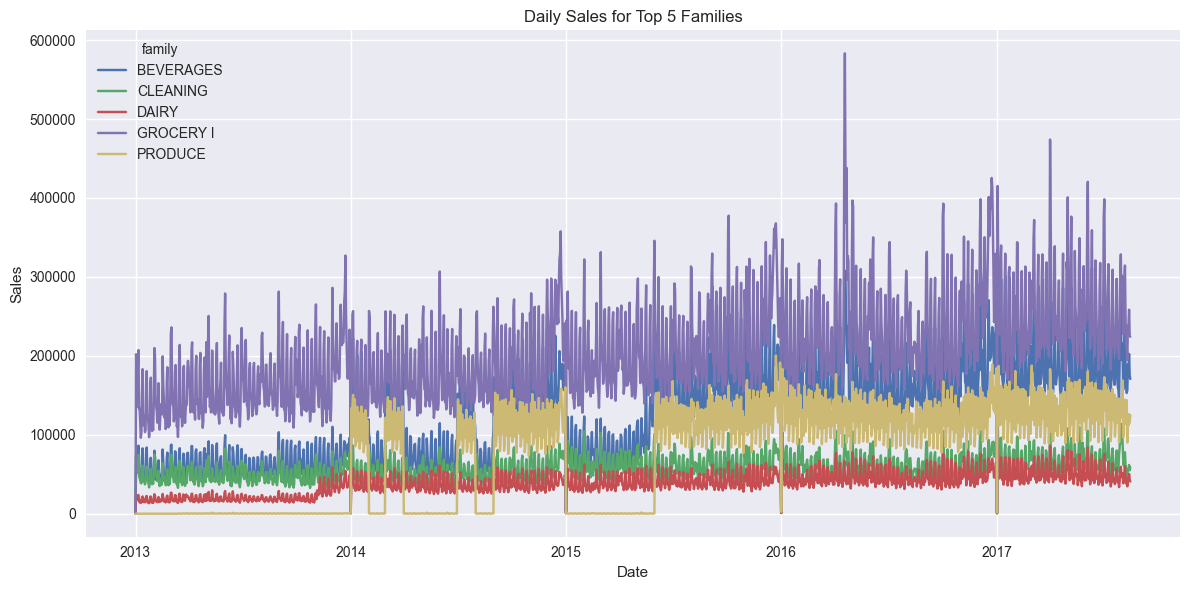

In [17]:
top_families = (
    df.groupby("family")["sales"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

df_top_fam = df[df["family"].isin(top_families)]

family_daily = (
    df_top_fam.groupby(["date", "family"])["sales"]
    .sum()
    .reset_index()
)

sns.lineplot(
    data=family_daily,
    x="date",
    y="sales",
    hue="family"
)
plt.title("Daily Sales for Top 5 Families")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


## 7. Key EDA Findings

- Датасет содержит более 3 миллионов наблюдений и не имеет пропущенных значений.
- Продажи демонстрируют выраженный долгосрочный тренд и сильную сезонность.
- Недельные и месячные циклы оказывают существенное влияние на спрос.
- Распределение продаж асимметрично и содержит экстремальные значения,
  отражающие реальные бизнес-события.
- Магазины и товарные категории характеризуются различными масштабами
  и уровнями волатильности продаж.
- Признак `onpromotion` потенциально играет важную роль
  в объяснении всплесков спроса.

Полученные выводы будут использованы
при построении baseline-моделей,
выборе метрик качества
и разработке более сложных моделей прогнозирования.
